# Exercise 05) Temporal-Difference Learning

In this exercise we again use the racetrack environment developed in the first homework.
You can either use our provided environment or your own solution from the homework assignment.  

For starting, please execute the following cells. 
There, we will build the more complex rectangular course which was used in the last task of exercise 04.

A dummy policy is defined, which turns the car to the right in front of a wall.
As a reminder the action encoding can be seen in the following picture:

![](Directions_Legend.png)

In [1]:
import numpy as np
import random
from racetrack_environment import RaceTrackEnv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from utils import build_rect_course

In [3]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)


course = build_rect_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY]) * 4

y_size, x_size = track.bounds

In [4]:
# setup dummy policy

dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5 # turn right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0 , :] = 6 # turn down left
dummy_slow_pi[-2:, track.bounds[1]//2:, : , 0] = 0 # turn up left
dummy_slow_pi[track.bounds[0]//2:, :2, 0, :] = 2 # turn up right
dummy_slow_pi[:2, 0:track.bounds[1]//2, :, 0] = 8 # turn down right

pi = dummy_slow_pi

WWWWWWWWWWWW
Woooo+W-oooW
Woooo+W-oooW
Woooo+W-oooW
WooWWWWWWooW
WooWWWWWWooW
WooooooooooW
WooooooooooW
WooooooooooW
WWWWWWWWWWWW

 
 Sample trajectory on dummy policy:


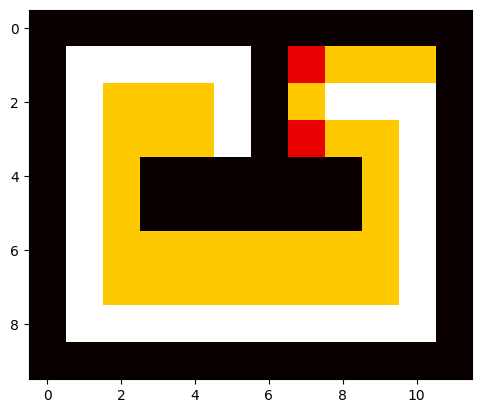

In [5]:
# Run learned policy on test case
pos_map = np.zeros((y_size, x_size))
state = track.reset()
for k in range(2000):
    pos_map[state[0], state[1]] += 1  # exploration map
    act = track.action_to_tuple(pi[state])
    state, reward, terminated, truncated, _ = track.step(act)
    if truncated: state = track.reset()
    if terminated: break    

for row in course:
    print(row)

print('\n \n Sample trajectory on dummy policy:')
pos_map = (pos_map > 0).astype(np.float32)
pos_map +=  track.course  # overlay track course
plt.imshow(pos_map, cmap='hot', interpolation='nearest')
plt.show()

## 1) TD-Based Prediction (Policy Evaluation)

Write a TD-based prediction algorithm to evaluate the dummy policy using $\alpha = 0.2$ and $\gamma = 1$ and calculate the state values.

After how many episodes do the state values converge?
Compare this to Monte-Carlo first visit prediciton from exercise 04.

Change $\alpha$ to $1$? Does it work? Explain!

## 1) Solution

In [6]:
def text_print_pos_map(_pos_map):
    """Function to print the state values"""
    for row in _pos_map:
        print(' '.join(x_size*['{}']).format(*[str(int(r)).zfill(3) for r in row]))

def plot_pos_map(_pos_map):
    """# Function to plot the heatmap"""
    plt.imshow(_pos_map, cmap='hot', interpolation='nearest')
    plt.show()


def interact(pi, state):
    """Interact with the environment to get to the next state.

    Args:
        pi: The policy to follow
        state: The current state before interaction

    Returns:
        next_state: The next state after interaction
        reward: The reward for the current interaction
        terminated: If the goal was reached
        truncated: If the boundary of the track was breached
    """
    ### BEGIN SOLUTION

    action = track.action_to_tuple(pi[state])
    next_state, reward, terminated, truncated, _ = track.step(action)

    ### END SOLUTION
    return next_state, reward, terminated, truncated

def learn(values, state, next_state, reward, gamma, alpha):
    """Learn from the collected data using TD0-based prediction.
    
    Args:
        values: The state-value estimates before the current update
        state: The state before the last interaction
        next_state: The state after the last interaction
        reward: The reward for the last interaction
        gamma: Discount factor
        alpha: Forgetting factor
    """
    ### BEGIN SOLUTION

    values[state] += alpha * (reward + gamma*values[next_state] - values[state])

    ### END SOLUTION
    return values

episode:   0%|          | 0/250 [00:00<?, ?it/s]

000 000 000 000 000 000 000 000 000 000 000 000
000 -04 -03 -02 -01 000 000 -30 -29 -28 -27 000
000 -05 000 000 000 000 000 -29 -28 -27 -26 000
000 -06 000 000 000 000 000 -28 -27 -26 -25 000
000 -07 000 000 000 000 000 000 000 000 -24 000
000 -08 000 000 000 000 000 000 000 000 -23 000
000 -09 000 000 000 000 000 000 000 000 -22 000
000 -10 000 000 000 000 000 000 000 000 -21 000
000 -11 -12 -13 -14 -15 -16 -17 -18 -19 -20 000
000 000 000 000 000 000 000 000 000 000 000 000


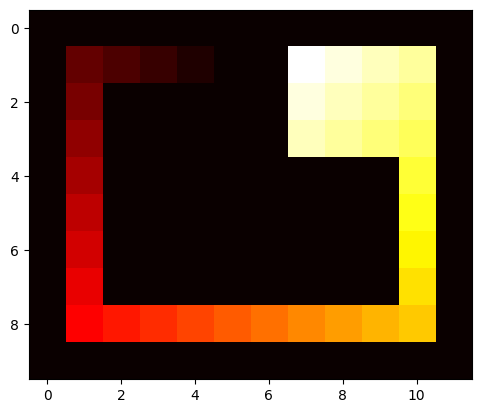

In [7]:
# Initialise state values 
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# Configuration parameters
gamma = 1
alpha = 1

# Initialise race track course
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

pos_map = np.zeros((y_size, x_size))

episodes = 250

for e in tqdm(range(episodes), desc='episode'): 
        
    # initialize x0
    state = track.reset()
  
    # episodes do not terminate by time limit
    while True:
        next_state, reward, terminated, truncated = interact(pi, state)

        if truncated: 
            next_state = track.reset()

        values = learn(values, state, next_state, reward, gamma, alpha)        
        
        # x_k = x_k+1
        state = next_state

        if terminated:
            break

    # update map
    for s_x in range(x_size):
        for s_y in range(y_size):
            pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])
     
text_print_pos_map(pos_map)
  
# Plot heatmap in the end
plot_pos_map(-pos_map)

## 2) On-Policy $\varepsilon$-Greedy Control: 

Write a temporal-difference based $\varepsilon$-greedy control algorithm to solve the rectangular course environment used above. 
Use $\varepsilon = 0.1$, $\alpha = 0.5$ and $\gamma = 1$ and run $500$ episodes.

Note that no initial policy is needed for TD control methods. 


Does Sarsa perform good at learning an optimal greedy policy?

Change $\alpha$ to $0.1$ and $0.9$. What do you recognize? Explain!

## 2) Solution

Algorithm given below.

As a soft exploration policy $\pi$ is used for training, the $q_\pi$ that is derived from that will be biased due to $\pi$ being soft and not optimally greedy.

Changing $\alpha$ to 0.1 will result in a less biased policy. 
But the training will need more time because the action value updates are smaller due to the lower learning rate $\alpha$:

$q(x_\mathrm{k}, u_\mathrm{k}) = q(x_\mathrm{k}, u_\mathrm{k}) + \alpha [r_\mathrm{k+1} + \gamma q(x_\mathrm{k+1}, u_\mathrm{k+1}) - q(x_\mathrm{k}, u_\mathrm{k}) ] $

In [8]:
def policy(action_values, state, deterministic, epsilon):
    """Decides on one of the actions in dependence of the current state.

    Args:
        action_values: The current action values
        state: The state vector
        deterministic: Whether actions are chosen deterministically or eps-greedily
        epsilon: Probability for random action in eps-greedy

    Returns:
        action: The chosen action
    """
    ### BEGIN SOLUTION

    if epsilon < np.random.rand(1) or deterministic:
        # argmax takes the action whose action value is the highest for the given state
        action = np.argmax(action_values[state])
    else:
        action = random.choice(range(9))

    ### END SOLUTION
    return action


def learn(action_values, state_action, next_state_action, reward, gamma, alpha):
    """Learn from the collected data using TD0-based prediction.
    
    Args:
        action_values: The action-value estimates before the current update
        state_action: The state+action before the last interaction
        next_state_action: The state+action for the next interaction
        reward: The reward for the last interaction
        gamma: Discount factor
        alpha: Forgetting factor
    """
    ### BEGIN SOLUTION

    action_values[state_action] += alpha * (reward + gamma*action_values[next_state_action]-action_values[state_action])

    ### END SOLUTION
    return action_values

episode:   0%|          | 0/500 [00:00<?, ?it/s]

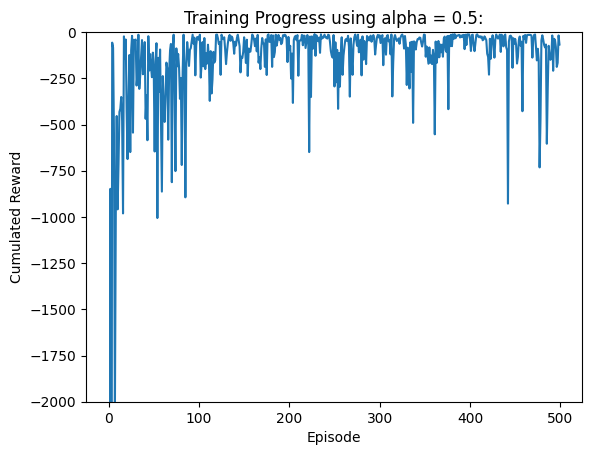

In [9]:
# Initialise action values 
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])

cumulated_rewards = []
q_sample = []

# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 1       # discount factor
alpha = 0.5     # forgetting factor
n_episodes = 500 # number of evaluated episodes

# define track
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

### BEGIN SOLUTION

for e in tqdm(range(n_episodes), desc='episode'): 
    cumulated_reward = 0
    
    pos_map = np.zeros((y_size, x_size))
    
    state = track.reset()

    # get first action
    action = policy(action_values, state, False, epsilon)
    action = track.action_to_tuple(action)
    state_action = track.state_action(state, action)

    # episodes do not terminate by time limit
    while True:
        pos_map[state[0], state[1]] += 1  # exploration map

        next_state, reward, terminated, truncated, _ = track.step(action)
        if truncated:
            next_state = track.reset()

        # get action for the next step
        next_action = policy(action_values, next_state, False, epsilon)
        next_action = track.action_to_tuple(next_action)
        next_state_action = track.state_action(next_state, next_action)
        
        action_values = learn(
            action_values, state_action, next_state_action, reward, gamma, alpha
        )

        # save variables for the next iteration
        action = next_action
        state = next_state
        state_action = next_state_action

        cumulated_reward += reward
        if terminated:
            break
    
    cumulated_rewards.append(cumulated_reward)      
        
### END SOLUTION    
    
plt.plot(cumulated_rewards)
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('Cumulated Reward')
plt.ylim(-2000, 0) 
plt.show()

Use the following code to apply the best policy. Due to the random start position, do $5$ iterations.

Sample trajectory on learned policy in episode 0:


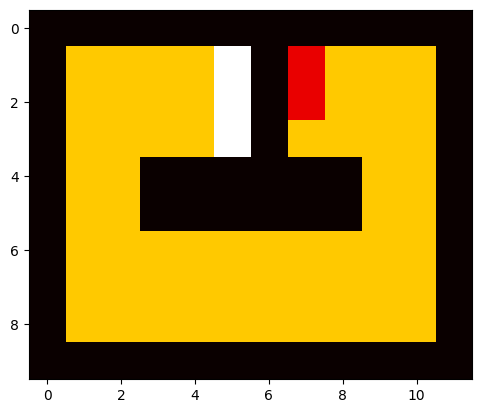

Sample trajectory on learned policy in episode 1:


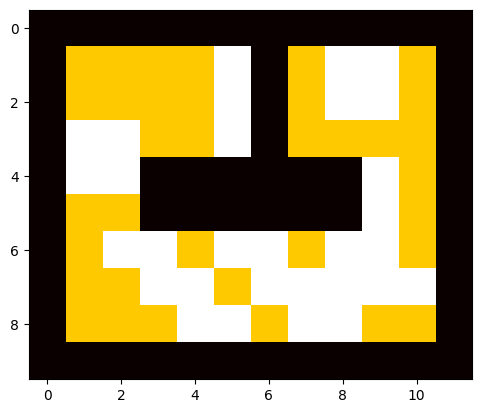

Sample trajectory on learned policy in episode 2:


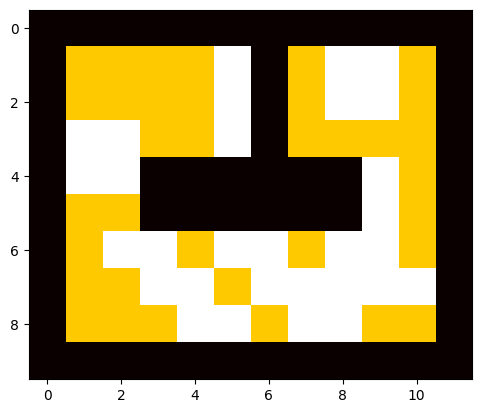

Sample trajectory on learned policy in episode 3:


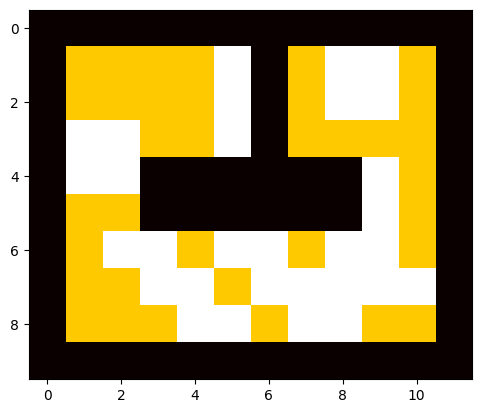

Sample trajectory on learned policy in episode 4:


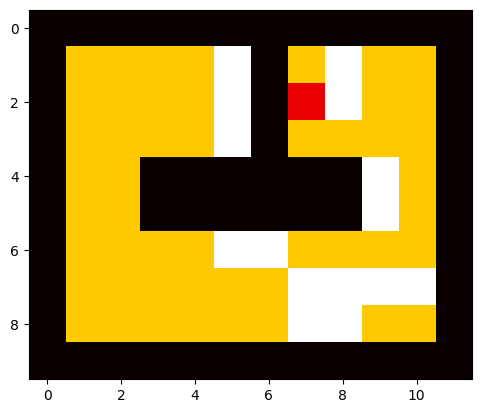

In [10]:
def evaluate_policy(action_values, n_episodes=5):
    for e in range(n_episodes):
        state_actions = []
        rewards = []

        pos_map = np.zeros((y_size, x_size))
        state = track.reset()
        for k in range(200):

            pos_map[state[0], state[1]] += 1  # exploration map

            action = policy(action_values, state, deterministic=True, epsilon=epsilon)
            action = track.action_to_tuple(action)
            
            state_action = track.state_action(state, action)
            state_actions.append(state_action)

            state, reward, terminated, truncated, _ = track.step(action)
            
            rewards.append(reward)

            if truncated:
                state = track.reset()

            if terminated:
                print('Done')
                break 

        print('Sample trajectory on learned policy in episode {}:'.format(e))
        pos_map = (pos_map > 0).astype(np.int16)
        pos_map +=  track.course  # overlay track course
        plt.imshow(pos_map, cmap='hot', interpolation='nearest')
        plt.show()


evaluate_policy(action_values)

## 3) Off-Policy $\varepsilon$-Greedy Control: Q-Learning

Write a function for a Q-Learning algorithm to solve the rectangular course environment (function will be re-used in the next task).
Use again $\varepsilon = 0.1$, $\alpha = 0.5$, $\gamma = 1$ and 500 episodes.

Can the resulting greedy policy be expected to be better or worse than the optimal policy trained with Sarsa?


## 3) Solution

Algorithm given below.

Q-learning determines its action values based on the idea that an optimal greedy policy is acquired in the end (hence the $\text{max} \, q$ operation when updating the action values). Thus, the resulting policy is not biased towards softness of the exploration policy, but towards assumption of optimality (maximization bias).
In this example the reward is deterministic, so maximization bias is not a problem and $\alpha$ only influences the speed of learning. 


In [11]:
def interact(action_values, state, epsilon):
    """Interact with the environment to get to the next state.
    You may reuse the policy function from task 2) within this
    function.

    Args:
        action_values: The action-value estimates
        state: The current state before interaction
        epsilon: The probability for a random action

    Returns:
        next_state: The next state after interaction
        reward: The reward for the current interaction
        terminated: If the goal was reached
        truncated: If the boundary of the track was breached
        action: The applied action
    """
    ### BEGIN SOLUTION
    action = policy(action_values, state, False, epsilon)
    action = track.action_to_tuple(action)

    next_state, reward, terminated, truncated, _ = track.step(action)

    ### END SOLUTION
    return next_state, reward, terminated, truncated, action


def learn(action_values, state, action, next_state, reward, gamma, alpha):
    """Learn from the collected data with a q-learning update step.
    
    Args:
        action_values: The action-value estimates before the update step
        state: The state before the interaction
        action: The chosen action
        next_state: The next state after the interaction
        reward: The reward for the interaction
        gamma: Discount factor
        alpha: Step size

    Returns:
        action_values: The updated action-value estimates
    """
    ### BEGIN SOLUTION
    
    state_action = track.state_action(state, action)
    action_values[state_action] += alpha * (reward + gamma*np.max(action_values[next_state])-action_values[state_action])
    
    ### END SOLUTION
    return action_values


def q_learning(epsilon, gamma, alpha, episodes, track):
    """Defines the Q-learning function which performs 𝜀-greedy control on the given track.

    Args:
        epsilon: Exploration probability
        gamma: Discount factor
        alpha: Forgetting factor
        episodes: Number of evaluated episodes
        track: Race track to learn

    Returns:
        cumulated_rewards: List of accumulated rewards per episode
        action_values: The learned action values
    """
    # define track
    course = track.course
    x_size, y_size = len(course[0]), len(course)
    
    # Initialise action values 
    action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
    
    cumulated_rewards = []

    ### BEGIN SOLUTION

    for e in tqdm(range(episodes), desc='episode'): 
        cumulated_reward = 0

        pos_map = np.zeros((y_size, x_size))
        state = track.reset()   

        # episodes do not terminate by time limit
        while True:
            pos_map[state[0], state[1]] += 1  # exploration map

            next_state, reward, terminated, truncated, action = interact(action_values, state, epsilon)

            if truncated:
                next_state = track.reset()

            action_values = learn(action_values, state, action, next_state, reward, gamma, alpha)

            state = next_state
            
            cumulated_reward += reward
            if terminated:
                break
        
        cumulated_rewards.append(cumulated_reward) 
        
    ### END SOLUTION
    return cumulated_rewards, action_values

episode:   0%|          | 0/500 [00:00<?, ?it/s]

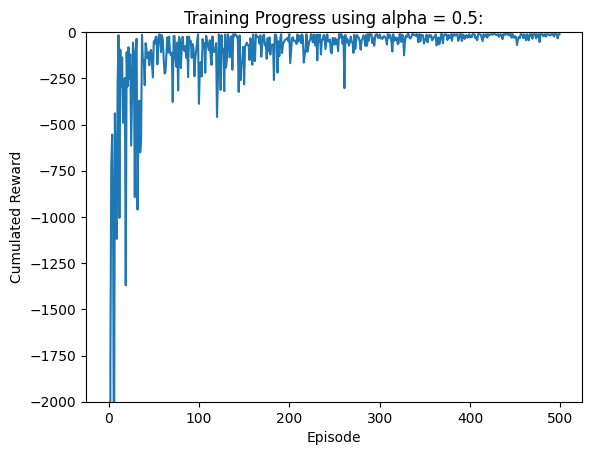

In [12]:
# configuration parameters
epsilon = 0.1   # exploration probability
gamma = 1       # discount factor
alpha = 0.5      # forgetting factor
episodes = 500 # number of evaluated episodes

# define track using the course defined above
course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

cumulated_rewards, action_values = q_learning(epsilon, gamma, alpha, episodes, track)

plt.plot(cumulated_rewards)
plt.title('Training Progress using alpha = {}:'.format(alpha))
plt.xlabel('Episode')
plt.ylabel('Cumulated Reward')
plt.ylim(-2000, 0) 
plt.show()

Show again the best 5 episodes using the function defined in 2)

Done
Sample trajectory on learned policy in episode 0:


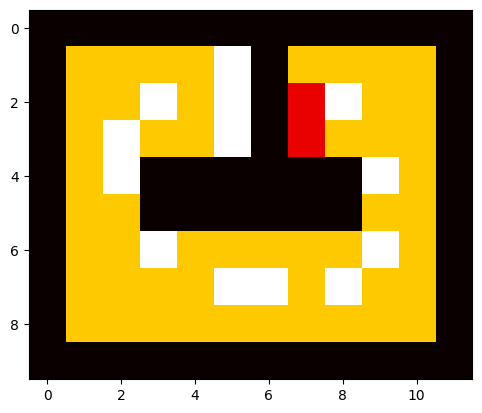

Done
Sample trajectory on learned policy in episode 1:


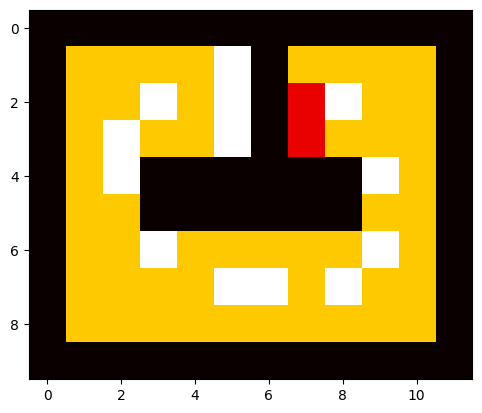

Done
Sample trajectory on learned policy in episode 2:


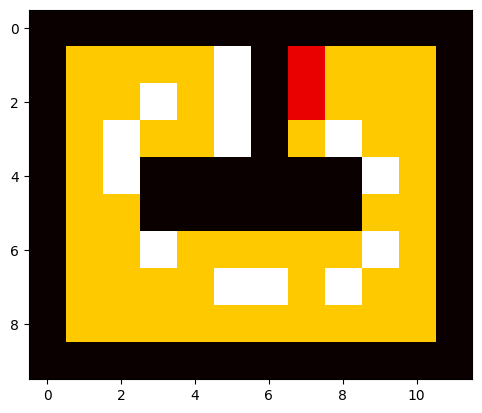

Done
Sample trajectory on learned policy in episode 3:


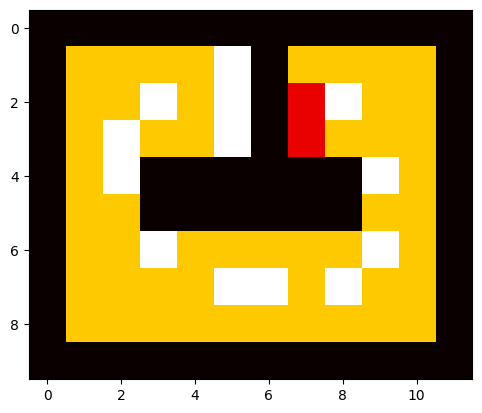

Done
Sample trajectory on learned policy in episode 4:


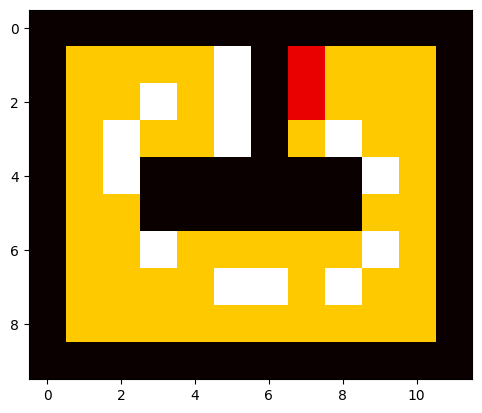

In [13]:
evaluate_policy(action_values)

## 4) Double Q-Learning

Now assume the driver had a few beers. Due to the alcohol he/she is not able to perceive the environment in detail.
The reward is therefore stochastic whenever an action, that accelerates the car into the direction of a corner, is selected (e.g. [-1,1] in the upper right quadrant).
A corresponding stochastic environment is given below. 
Execute the cell before continuing with the exercise.

- Use this environment and try to solve it with the Q-learning function written in 3) using $\varepsilon = 0.1$, $\alpha = 0.5$ and $\gamma = 1$ with the cells given below.

A code template is given which repeats the training $3$ times to calculate the mean cumulated reward.


- Write a double Q-learning algorithm to solve the above defined course with the given template.
Use again $\varepsilon = 0.1$, $\alpha = 0.5$ and $\gamma = 1$.

Compare the results.

### Drunken Driver Environment

In [14]:
from racetrack_environment import StochRaceTrackEnv

Experiment:   0%|          | 0/4 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

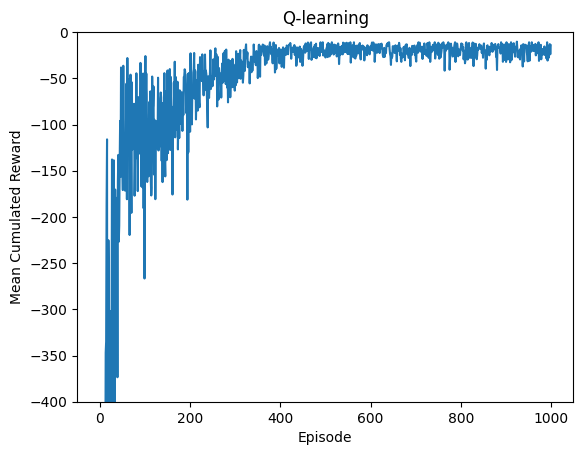

In [15]:
# configuration parameters
epsilon = 0.1    # exploration probability
gamma = 1        # discount factor
alpha = 0.5      # forgetting factor
episodes = 1000  # number of evaluated episodes
repetitions = 4  # repeats the training to get mean reward

# define track using the course defined above
track = StochRaceTrackEnv(course=course)

reward_trajectories_Q = []
policies_Q = []

# Runs training repetitions-times
for _ in tqdm(range(repetitions), desc='Experiment'):
    
    # Execute q-learning
    cumulated_rewards, action_values = q_learning(epsilon, gamma, alpha, episodes, track)
    
    # store reward and policy
    reward_trajectories_Q.append(cumulated_rewards)
    policies_Q.append(action_values)
    
plt.plot(np.vstack(reward_trajectories_Q).mean(axis=0))
plt.title('Q-learning')
plt.xlabel('Episode')
plt.ylabel('Mean Cumulated Reward')
plt.ylim(-400, 0) 
plt.show()

Done
Sample trajectory on learned policy in episode 0:


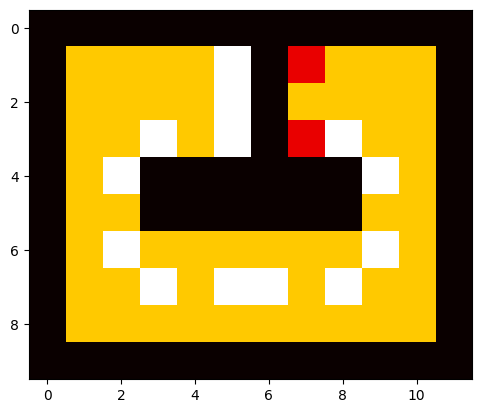

Done
Sample trajectory on learned policy in episode 1:


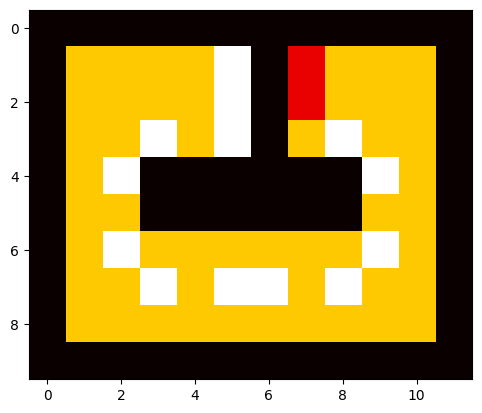

Done
Sample trajectory on learned policy in episode 2:


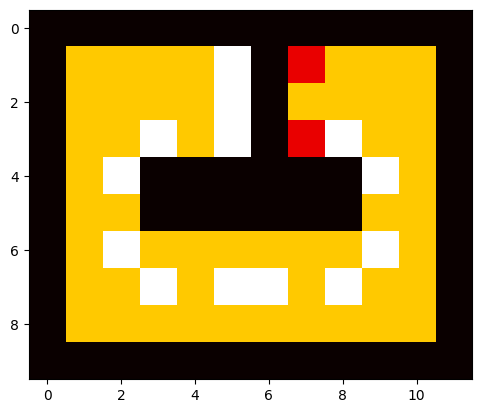

Done
Sample trajectory on learned policy in episode 3:


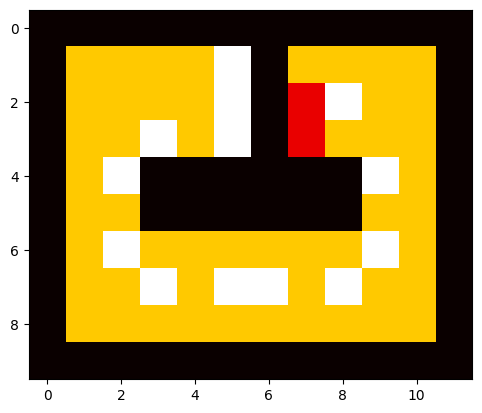

Done
Sample trajectory on learned policy in episode 4:


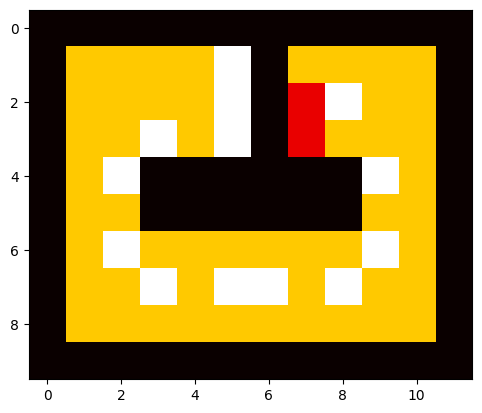

Done
Sample trajectory on learned policy in episode 5:


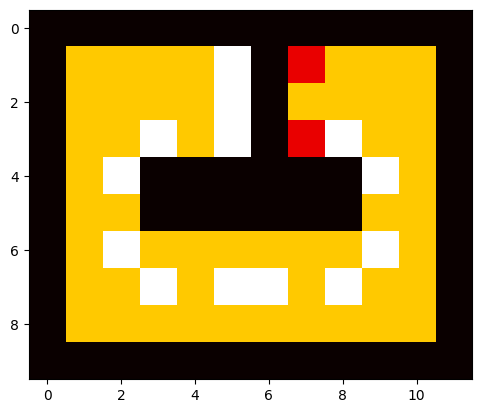

Done
Sample trajectory on learned policy in episode 6:


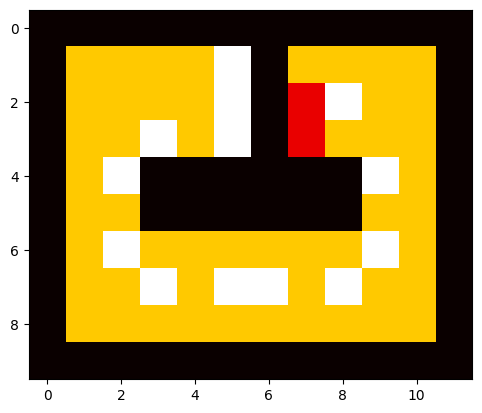

Done
Sample trajectory on learned policy in episode 7:


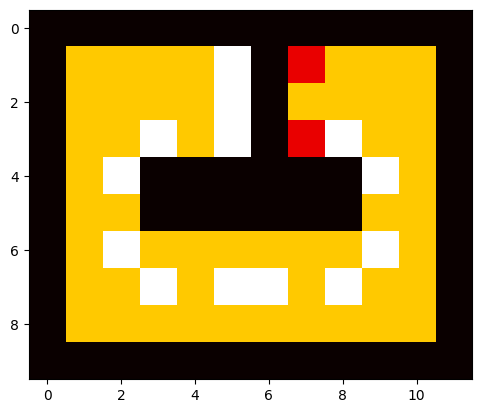

Done
Sample trajectory on learned policy in episode 8:


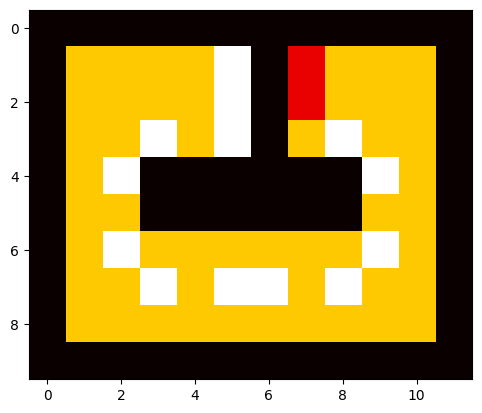

Done
Sample trajectory on learned policy in episode 9:


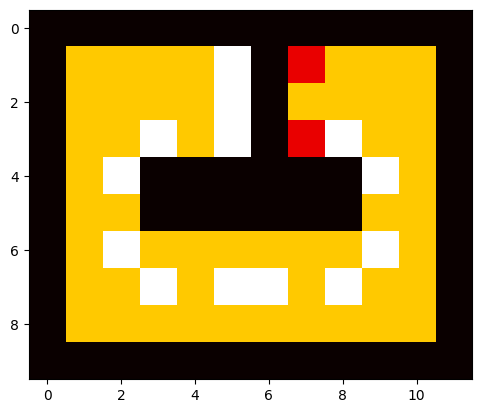

In [16]:
# show episodes
# Uses last calulated Q-values to evaluate the policy
evaluate_policy(policies_Q[-1], 10)

## 4) Solution

Double Q-Learning is especially useful if the environment itself is random e.g. in the form of stochastic rewards. But it uses more memory without special upsides in deterministic scenarios.

In [17]:
def learn(action_values1, action_values2, state, action, next_state, reward, gamma, alpha):
    """Learn from the collected data with a double q-learning update step.

    Args:
        action_values1: Set 1 of action value estimates before the update
        action_values2: Set 2 of action value estimates before the update
        state: The state before the interaction
        action: The chosen action
        next_state: The next state after the interaction
        reward: The reward for the interaction
        gamma: Discount factor
        alpha: Step size

    Returns:
        action_values1: Set 1 of updated action value estimates
        action_values2: Set 2 of updated action value estimates
    """
    ### BEGIN SOLUTION

    state_action = track.state_action(state, action)
    
    if np.random.rand() > 0.5:
        q2_argmax_q1 = np.ravel(action_values2[next_state])[np.argmax(action_values1[next_state])]
        action_values1[state_action] += alpha * (reward + gamma*q2_argmax_q1 - action_values1[state_action])
    else:
        q1_argmax_q2 = np.ravel(action_values1[next_state])[np.argmax(action_values2[next_state])]
        action_values2[state_action] += alpha * (reward + gamma*q1_argmax_q2 - action_values2[state_action]) 

    ### END SOLUTION
    return action_values1, action_values2


def double_q_learning(epsilon, gamma, alpha, episodes, track):
    """
    Defines the double Q-learning function which performs 𝜀-greedy control on the given track.

    Args:
        epsilon: Exploration probability
        gamma: Discount factor
        alpha: Forgetting factor
        episodes: Number of evaluated episodes
        track: Race track to learn
    
    Returns:
        cumulated_rewards: The accumulated rewards per episode 
        action_values: The action_value estimate
    """
    
    # define track
    course = track.course
    x_size, y_size = len(course[0]), len(course)
    
    # Initialise action values 
    action_values1 = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
    action_values2 = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
    
    cumulated_rewards = []
    
    ### BEGIN SOLUTION
    
    for e in tqdm(range(episodes), desc='episode'): 
        cumulated_reward = 0

        pos_map = np.zeros((y_size, x_size))
        state = track.reset()     
        
        # episodes do not terminate by time limit
        while True:
            pos_map[state[0], state[1]] += 1  # exploration map

            next_state, reward, terminated, truncated, action = interact(
                action_values=action_values1+action_values2,
                state=state,
                epsilon=epsilon
            )

            if truncated:
                next_state = track.reset()

            action_values1, action_values2 = learn(
                action_values1, action_values2, state, action, next_state, reward, gamma, alpha
            )

            state = next_state
            
            cumulated_reward += reward
            if terminated:
                break

        cumulated_rewards.append(cumulated_reward)      
        
    ### END SOLUTION
    
    return cumulated_rewards, action_values1+action_values2

Experiment:   0%|          | 0/4 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode:   0%|          | 0/1000 [00:00<?, ?it/s]

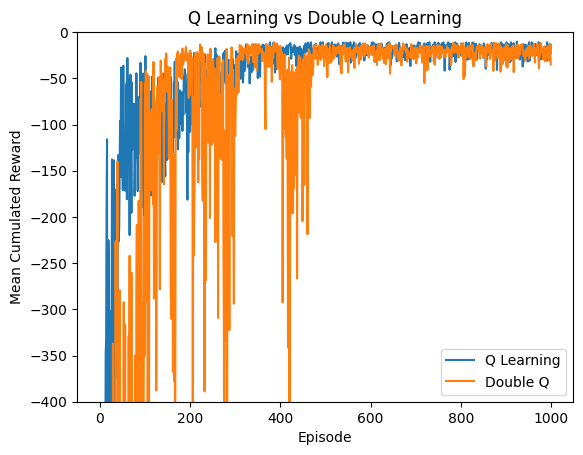

In [18]:
reward_trajectories_double_Q = []
policies_double_Q = []

# Runs training repetitions-times
for _ in tqdm(range(repetitions), desc='Experiment'):
    
    # Execute double q-learning
    cumulated_rewards, action_values = double_q_learning(epsilon, gamma, alpha, episodes, track)
    
    # store reward and policy
    reward_trajectories_double_Q.append(cumulated_rewards)
    policies_double_Q.append(action_values)
    
plt.plot(np.vstack(reward_trajectories_Q).mean(axis=0), label='Q Learning')
plt.plot(np.vstack(reward_trajectories_double_Q).mean(axis=0), label='Double Q')
plt.title('Q Learning vs Double Q Learning')
plt.xlabel('Episode')
plt.ylabel('Mean Cumulated Reward')
plt.ylim(-400, 0) 
plt.legend()
plt.show()

Show again the best $5$ episodes using the function defined in 2).

Done
Sample trajectory on learned policy in episode 0:


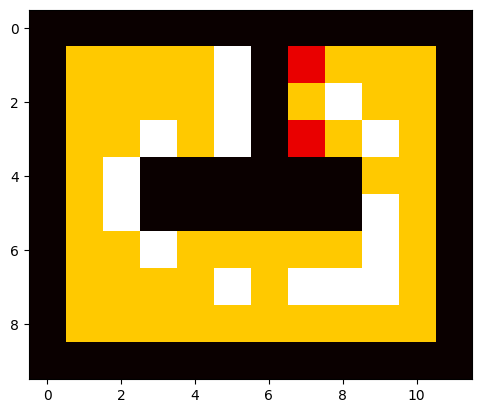

Done
Sample trajectory on learned policy in episode 1:


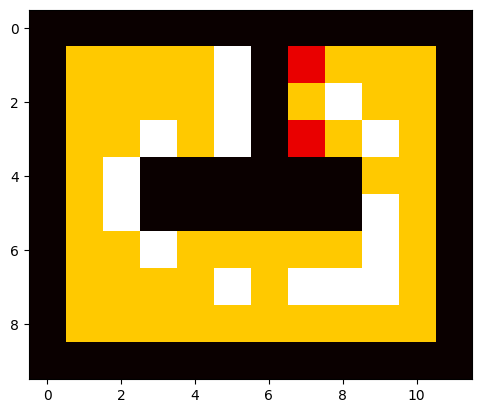

Done
Sample trajectory on learned policy in episode 2:


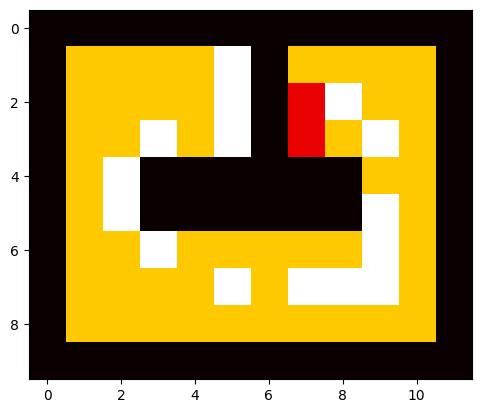

Done
Sample trajectory on learned policy in episode 3:


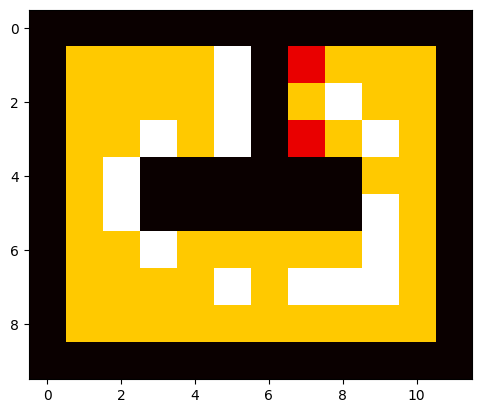

Done
Sample trajectory on learned policy in episode 4:


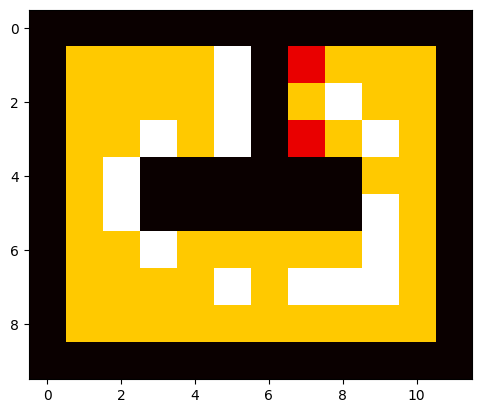

Done
Sample trajectory on learned policy in episode 5:


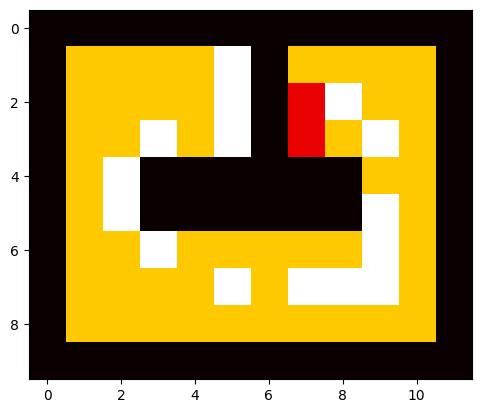

Done
Sample trajectory on learned policy in episode 6:


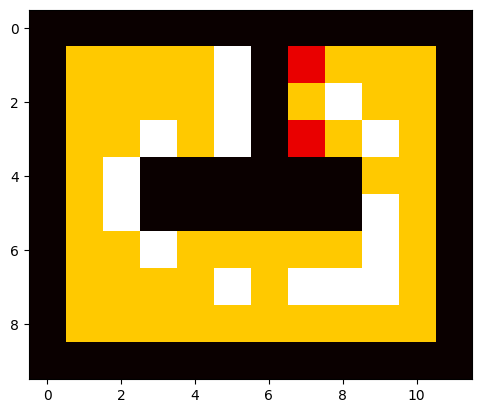

Done
Sample trajectory on learned policy in episode 7:


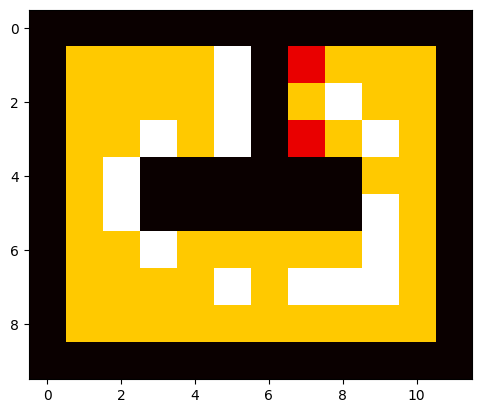

Done
Sample trajectory on learned policy in episode 8:


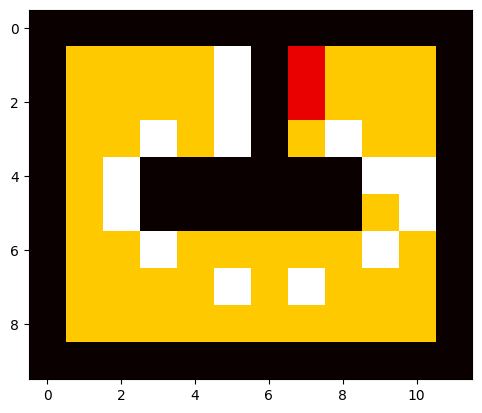

Done
Sample trajectory on learned policy in episode 9:


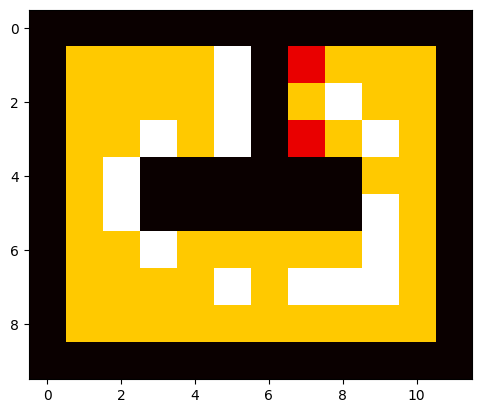

In [19]:
# Uses last calulated Q-values to evaluate the policy
evaluate_policy(policies_double_Q[-1], 10)